# Feature importance analysis

In this notebook, we explore the importance of each SNP to DiabNet neural network, using the [Integrated Gradients](https://arxiv.org/pdf/1703.01365.pdf) method.

## Imports and configuration

In [74]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from pandas.plotting import parallel_coordinates
from sklearn.metrics import r2_score

# Import custom functions
from diabnet.data import get_feature_names
from diabnet.ensemble import Ensemble
from diabnet.analysis.analysis import ExplainModel, get_feature_importance

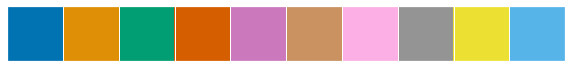

In [2]:
# Configuring IPython 
%load_ext autoreload
%autoreload 2

# Configuring matplotlib
%matplotlib inline

# Configuring color palette
sns.set()
colors = sns.color_palette("colorblind")
sns.palplot(colors)
sns.set_style("whitegrid")
sns.set_style("ticks",{'axes.grid': True,'grid.color': '.95', 'grid.linestyle': '-', 'grid.zorder': 0})

# Save plots to files
SAVE = True

# Verbosity
VERBOSE = False

## Loading ensemble data

In [3]:
# Loading ensemble
ensemble = Ensemble('../results/models/positive/model-positive-13-adamw-lc5-2021-05-25')

In [4]:
# Get feature names
feature_names = get_feature_names(
    "../data/visits_sp_unique_train_positivo_1000_random_0.csv",
    use_sex=True,
    use_parents_diagnosis=True,
)

## Get feature attribution for training and test datasets

In [5]:
# Feature attribution using training dataset
e_train = ExplainModel(
    ensemble, 
    feature_names, 
    "../data/visits_sp_unique_train_positivo_1000_random_0.csv"
)

In [6]:
# Feature attribution using test dataset
e_test = ExplainModel(
    ensemble, 
    feature_names, 
    "../data/visits_sp_unique_test_positivo_1000_random_0.csv"
)

## Get feature importance for training and test datasets

Evaluate the importance of SNPs regardless of other characteristics (sex, parents' diagnosis, age*).

(*) To make it age independent we set the age at 50.

In [7]:
age = 50
sex = 'X' # 'X' means any sex ('F', 'M')

Since there is no consensus on whether feature importance analysis should be performed on training or testing data, we use both datasets.

In [8]:
# Feature importance on training data
df_feat_imp_50_X_train = get_feature_importance(e_train, 50, 'X')

In [9]:
# Feature importance on test data
df_feat_imp_50_X_test = get_feature_importance(e_test, 50, 'X')

However, the test set has 44 out of 1000 SNPs that do not have the recessive allele (values 1 or 2) of the base gene and consequently, we were unable to assign an importance value. As we can see from the boxplot below, most of them can be important.

In [10]:
# Get SNPs that does not have variance on the test set
excluded = df_feat_imp_50_X_train[df_feat_imp_50_X_train.index.isin(df_feat_imp_50_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs have no variance on the test set, thus no feature importance can be calculated for them!")

44 SNPs have no variance on the test set, thus no feature importance can be calculated for them!


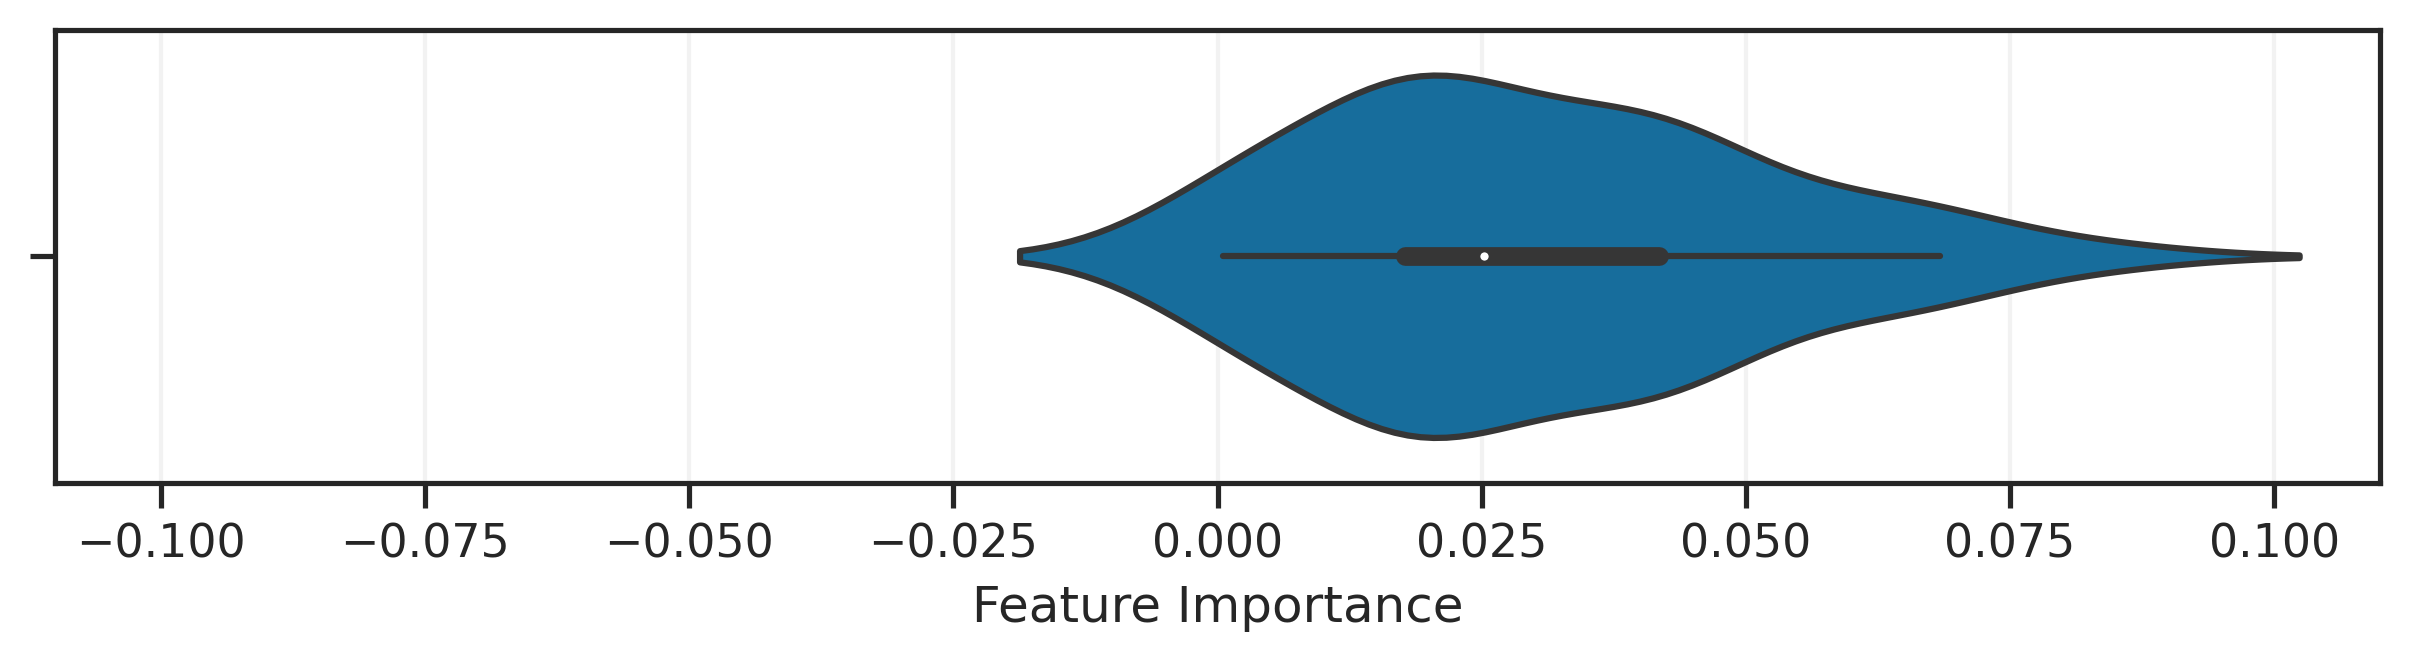

In [11]:
# Create figure
fig, ax = plt.subplots(1, figsize=(10, 2), dpi=300)

# Violin plot - SNPs that does not have variance on the test set
# Display values on the training set
sns.violinplot(data=excluded, x="X50_mean", inner="box", palette=colors, grid=True)

# Configuring plot
ax.set_ylabel(None)
ax.set_xlabel('Feature Importance')
ax.set_xlim(-0.11, 0.11)

# Display plot
plt.show()

In [12]:
# Join feature importance of training and testing data on a single pandas DataFrame
df_feat_imp_50_X = df_feat_imp_50_X_train.join(df_feat_imp_50_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_50_X['SNP'] = df_feat_imp_50_X.index
df_feat_imp_50_X = df_feat_imp_50_X.sort_values(by="X50_mean_train")

In [13]:
# Display data
display(df_feat_imp_50_X)

# NOTE: The 44 SPNs that did not have variance (no 1 or 2) on the test set. Hence, these SNPs were removed from
#  from this joint data.

,X50_mean_train,X50_median_train,X50_mean_test,X50_median_test,SNP
snp_17_15464147,-0.065130,-0.038196,-0.060568,-0.028964,snp_17_15464147
snp_4_181784699,-0.035120,-0.026343,-0.036541,-0.028241,snp_4_181784699
snp_21_11058226,-0.034126,-0.025021,-0.034343,-0.025724,snp_21_11058226
snp_16_19717582,-0.025540,-0.011897,-0.023971,-0.014204,snp_16_19717582
snp_16_82889990,-0.023126,-0.013550,-0.019479,-0.012004,snp_16_82889990
...,...,...,...,...,...
snp_3_124845764,0.080322,0.070339,0.071905,0.059450,snp_3_124845764
snp_8_37202618,0.081022,0.076411,0.085516,0.083130,snp_8_37202618
snp_10_15653813,0.082885,0.081144,0.065799,0.025906,snp_10_15653813
snp_11_120855337,0.086570,0.084095,0.095567,0.104761,snp_11_120855337


Comparing the mean and median of the calculated importance for the training and testing sets, we observe that there is a clear correlation (as expected). Therefore, we will choose to perform the subsequent analyzes only with the importance calculated in the training set. 


### Plot 1: Correlation and distribution of feature importance between training and test datasets

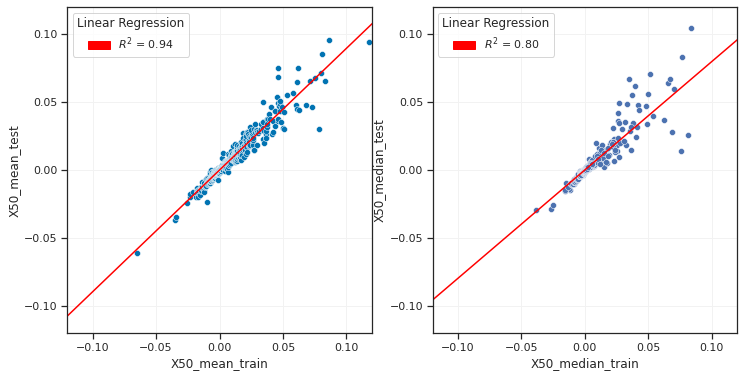

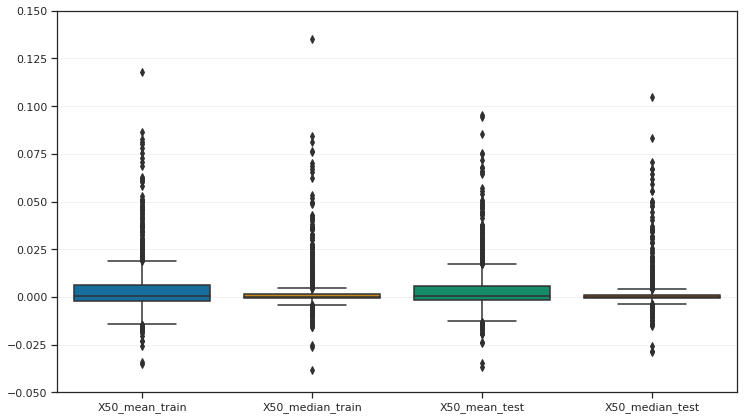

<Figure size 432x288 with 0 Axes>

In [84]:
# Create figure
plt.figure(figsize=(12,6));

# -- Subplot 1 -- #
plt.subplot(121);

# Scatter plot
sns.scatterplot(x="X50_mean_train", y="X50_mean_test", data=df_feat_imp_50_X, color=colors[0])

# Linear regression
m, b = np.polyfit(df_feat_imp_50_X["X50_mean_train"], df_feat_imp_50_X["X50_mean_test"], 1)
plt.plot(np.linspace(-.2, .2, num=10), m*np.linspace(-.2, .2, num=10) + b, label="Linear Regression", color='red')

# R2-score
R2 = mpatches.Patch(color='red', label=r'$R^2$ = {:.2f}'.format(r2_score(df_feat_imp_50_X["X50_mean_test"], m*df_feat_imp_50_X["X50_mean_train"] + b)))

# Configure plot
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)

# Configure legend
plt.legend(title='Linear Regression', handles=[R2])

# -- Subplot 2 -- #
plt.subplot(122);

# Scatter plot
sns.scatterplot(x="X50_median_train", y="X50_median_test", data=df_feat_imp_50_X)

# Linear regression
m, b = np.polyfit(df_feat_imp_50_X["X50_median_train"], df_feat_imp_50_X["X50_median_test"], 1)
plt.plot(np.linspace(-.2, .2, num=10), m*np.linspace(-.2, .2, num=10) + b, label="Linear Regression", color='red')

# R2-score
R2 = mpatches.Patch(color='red', label=r'$R^2$ = {:.2f}'.format(r2_score(df_feat_imp_50_X["X50_median_test"], m*df_feat_imp_50_X["X50_median_train"] + b)))

# Configure plot
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)

# Configure legend
plt.legend(title='Linear Regression', handles=[R2])

# -- Subplot 2 -- #
plt.figure(figsize=(10.5,6))

# Boxplot
sns.boxplot(data=df_feat_imp_50_X, palette=colors)

# Configure plot
plt.ylim(-0.05,0.15)

# Display plot
plt.tight_layout()
plt.show()

# Save figure to file
if SAVE:
    if not os.path.exists("./images"):
        os.makedirs("./images")
    plt.savefig("./images/notebook7-plot1.svg", dpi=300)

# Feature Importance

Qual a importância dos SNPs independentemente de outras características (sexo, diagnóstico dos pais, idade*).

*Para torna independente da idade fixamos a idade em 50.

In [ ]:
age = 50
sex = 'X' # 'X' significa qualquer sexo

Não há um consenso se a análise de importância das características (feature importance) deve ser feita com os dados de teste ou treinamento. Nós testamos os dois...

In [ ]:
df_feat_imp_50_X_train = feat_importance(e_train, 50, 'X')

In [ ]:
df_feat_imp_50_X_test = feat_importance(e_test, 50, 'X')

No entanto, no conjunto de teste 44 dos 1000 SNPs não possuem o gene base do alelo recessivo (valores 1 ou 2) e consequentemente, não conseguimos atribuir um valor de importância. E como notamos pelo boxplot abaixo, boa parte deles podem ser importantes.

In [ ]:
excluded = df_feat_imp_50_X_train[df_feat_imp_50_X_train.index.isin(df_feat_imp_50_X_test.index) == False]
print(f"{excluded.count()[0]} SNPs não tem valores no conjunto de teste")
sns.boxplot(y="X50_mean", data=excluded)

In [ ]:
df_feat_imp_50_X = df_feat_imp_50_X_train.join(df_feat_imp_50_X_test, how='inner', lsuffix='_train', rsuffix='_test')
df_feat_imp_50_X['SNP'] = df_feat_imp_50_X.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_X = df_feat_imp_50_X.sort_values(by="X50_mean_train")
df_feat_imp_50_X # apenas 956 pq 44 dos SNPs não tem valores 1 ou 2 no conjunto de teste 

Comparando a média e a mediana da importância calculada para os conjuntos de treinamento e teste podemos ver que há uma correlação significativa (como esperado). Logo, optaremos por realizar as análises subsequentes apenas com a importância calculada no conjunto de treinamento.

In [ ]:
plt.figure(figsize=(12,6));
plt.subplot(121);
# plt.scatter(tmp.X50_mean_train.values, tmp.X50_mean_test.values);
sns.scatterplot(x="X50_mean_train", y="X50_mean_test", data=df_feat_imp_50_X)
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)
plt.subplot(122);
# plt.scatter(tmp.X50_median_train.values, tmp.X50_median_test.values);
sns.scatterplot(x="X50_median_train", y="X50_median_test", data=df_feat_imp_50_X)
plt.ylim(-0.12,0.12)
plt.xlim(-0.12,0.12)
plt.figure(figsize=(12,4));
df_feat_imp_50_X.boxplot();

In [ ]:
sns.boxplot(y="X50_mean", data=df_feat_imp_50_X_train)

In [ ]:
df_feat_imp_50_X_train.describe()

In [ ]:
df_feat_imp_50_X_train["chr"] = [int(s.split('_')[1]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train["pos"] = [float(s.split('_')[2]) for s in df_feat_imp_50_X_train.index]
df_feat_imp_50_X_train

O gráfico da atribuição dos SNPs separado por cromossomo (abaixo) mostra que os chr 1 e 3 

In [ ]:
fig = plt.figure(figsize=(12,8), dpi=100)
plt.subplot(211)
sns.stripplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, jitter=0.15)
plt.subplot(212)
sns.violinplot(x="chr", y="X50_mean", data=df_feat_imp_50_X_train, whis=np.inf)

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=100)
plt.subplots_adjust(hspace=0.7, wspace=0.25)
for i in range(22):
    ax1=plt.subplot(8, 3, i+1)
    plt.title(f"chr: {i+1}")
    sns.scatterplot(x='pos', y="X50_mean", data=df_feat_imp_50_X_train[df_feat_imp_50_X_train["chr"]==i+1], hue="X50_mean", hue_norm=(-0.12,0.12), palette="RdBu_r", edgecolor="k")
    ax1.get_legend().remove()
    plt.ylim(-0.12,0.12)
    plt.ylabel("")
    plt.xlabel("")


In [ ]:
selection = df_feat_imp_50_X_train[abs(df_feat_imp_50_X_train['X50_mean'])> 0.05]

In [ ]:
# selection.sort_values(by='X50_mean').to_csv("feature_importance.csv")

In [ ]:
selection.sort_values(by='X50_mean', ascending=False)

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.subplot(211)
# sns.stripplot(x="chr", y="X50_mean", data=selection, jitter=0.15)
sns.swarmplot(x="chr", y="X50_mean", data=selection)
plt.subplot(212)
# sns.barplot(x="chr", y="X50_mean", data=selection)
sns.countplot(x="chr", data=selection)

## Análise por sexo

In [ ]:
# feature importance - M x F
# age: 50, set: test

In [ ]:
df_feat_imp_50_M_train = feat_importance(e_train, 50, 'M')
df_feat_imp_50_F_train = feat_importance(e_train, 50, 'F')

In [ ]:
df_feat_imp_50_FM_train = df_feat_imp_50_M_train.join(df_feat_imp_50_F_train, how='inner')
df_feat_imp_50_FM_train

In [ ]:
# tmp.sort_values(by="M50_mean").to_csv("feature_importance_sex.csv")

In [ ]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_mean", y="F50_mean", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [ ]:
# r² para os snps x sexo

In [ ]:
fig = plt.figure(figsize=(6,6))
sns.scatterplot(x="M50_median", y="F50_median", data=df_feat_imp_50_FM_train)
plt.ylim(-0.2,0.35)
plt.xlim(-0.2,0.35)

In [ ]:
df_feat_imp_50_FM_train.sort_values(by="F50_mean").tail(20)

In [ ]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
df_feat_imp_50_FM_train_selection = df_feat_imp_50_FM_train[abs((df_feat_imp_50_FM_train['M50_mean']+df_feat_imp_50_FM_train['F50_mean']))/2 > 0.05]
df_feat_imp_50_FM_train_selection['SNP'] = df_feat_imp_50_FM_train_selection.index
# parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
df_feat_imp_50_FM_train_selection.sort_values(by="M50_mean")

In [ ]:
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_50_FM_train_selection, 'SNP', cols=['M50_mean', 'F50_mean'] ).legend().remove() 

# SNP Importance - Lifelong variability

In [ ]:
df_feat_imp_by_age_train = feat_importance(e_train, 20, 'X') 
for age in range(30, 90, 10):
    df_feat_imp_by_age_train = df_feat_imp_by_age_train.join(feat_importance(e_train, age, 'X'),how='inner')

In [ ]:
# mean
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[abs(df_feat_imp_by_age_train['X80_mean']) > 0.03]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'mean' in i]).legend().remove() 

In [ ]:
# median
df_feat_imp_by_age_train_selection = df_feat_imp_by_age_train[abs(df_feat_imp_by_age_train['X80_median']) > 0.02]
df_feat_imp_by_age_train_selection['SNP'] = df_feat_imp_by_age_train_selection.index
fig = plt.figure(dpi=100)
parallel_coordinates(df_feat_imp_by_age_train_selection, 'SNP', cols=[i for i in df_feat_imp_by_age_train.columns if 'median' in i]).legend().remove() 

In [ ]:
# tmp = feat_imp_M50.join(feat_imp_F50, how='inner')
# tmp = tmp[abs((tmp['M50_mean']+tmp['F50_mean']))/2 > 0.04]
# tmp['SNP'] = tmp.index
# # parallel_coordinates(tmp, '1_M50', cols='M50_mean','F50_mean'])
# tmp.sort_values(by="M50_mean")

In [ ]:
# fig = plt.figure(dpi=100)
# parallel_coordinates(tmp, 'SNP', cols=['M50_mean', 'F50_mean'])

In [ ]:
# feat_imp_by_age = feat_importance(e_test, 20, 'X') 
# for age in range(30, 90, 10):
#     feat_imp_by_age = feat_imp_by_age.join(feat_importance(e_test, age, 'X'),how='inner')
    

In [ ]:
# [i for i in feat_imp_by_age.columns if 'mean' in i]

In [ ]:
# tmp = feat_imp_by_age[abs(feat_imp_by_age['X80_mean']) > 0.04]
# tmp['SNP'] = tmp.index
# parallel_coordinates(tmp, 'SNP', cols=[i for i in feat_imp_by_age.columns if 'mean' in i])

In [ ]:
df_feat_imp_by_age_train[['X80_median']].boxplot()

In [ ]:
feat_imp_M50.sort_values(by=0, ascending=False).head(50)

In [ ]:
imp = e_test.calc_attr(20, 'X', samples_per_model=1)

In [ ]:
s

In [ ]:
dfnew.sort_values(by=0, ascending=True).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
dfnew = pd.DataFrame.from_dict(s, orient='index')
dfnew.sort_values(by=0, ascending=False).head(50)

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(s, orient='index')

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
df.sort_values(by=0, ascending=True).head(50)

In [ ]:
import numpy as np
np.mean(df.values, axis=0)

In [ ]:
df_20_X = e_train.attr_snps_mean(attrs, mask).rename(columns={0: "age=20,sex=X"})

In [ ]:
df_20_X.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
attr, mask = e_train.calc_attr(20, 'X', samples=1)
df_20_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_train.calc_attr(20, 'M', samples=1)
df_20_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_train.calc_attr(20, 'F', samples=1)
df_20_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
df_decay2 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay2.head(20)

In [ ]:
df_decay1 = df_20_X.sort_values(by="age=20,sex=X", ascending=False)
df_decay1.head(20)

In [ ]:
df_train[df_train.index=='snp_4_172986805']

In [ ]:
attr, mask = e_train.calc_attr(50, 'X', samples=1)
df_50_X = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_train.calc_attr(50, 'M', samples=1)
df_50_M = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_train.calc_attr(50, 'F', samples=1)
df_50_F = e_train.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_train = df_20_X.join([df_20_F,df_20_M,df_50_X,df_50_F,df_50_M])

In [ ]:
df_train.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_train.sort_values(by="age=50,sex=X", ascending=False).tail(50)

In [ ]:
plt.boxplot(df_20_X.values)

In [ ]:
attr, mask = e_test.calc_attr(20, 'X', samples=1)
df_20_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=X"})
attr, mask = e_test.calc_attr(20, 'M', samples=1)
df_20_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=M"})
attr, mask = e_test.calc_attr(20, 'F', samples=1)
df_20_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=20,sex=F"})

In [ ]:
attr, mask = e_test.calc_attr(50, 'X', samples=1)
df_50_X_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=X"})
attr, mask = e_test.calc_attr(50, 'M', samples=1)
df_50_M_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=M"})
attr, mask = e_test.calc_attr(50, 'F', samples=1)
df_50_F_test = e_test.attr_snps_mean(attr, mask).rename(columns={0: "age=50,sex=F"})

In [ ]:
df_test = df_20_X_test.join([df_20_F_test,df_20_M_test,df_50_X_test,df_50_F_test,df_50_M_test])

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).head(50)

In [ ]:
df_test.sort_values(by="age=20,sex=X", ascending=False).tail(50)

In [ ]:
df = df_train.join(df_test, lsuffix='_train', rsuffix='_test')

In [ ]:
sns.pairplot(df.sort_values(by="age=20,sex=X_train", ascending=False).head(20))
# plt.savefig('pairplot.svg')

In [ ]:
df.sort_values(by="age=20,sex=X_train", ascending=False).head(20)

In [ ]:
df_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).head(100)

In [ ]:
df_sel

In [ ]:
tmp = dict(Counter([s[:s.index('_',4)] for s in list(df_sel.index)]))
sns.barplot(x=list(tmp.keys()), y=list(tmp.values()))

In [ ]:
df_not_sel = df.reindex(df["age=20,sex=X_train"].abs().sort_values(ascending=False).index).tail(500)

In [ ]:
Counter([s[:s.index('_',4)] for s in list(df_not_sel.index)])

In [ ]:
list(tmp.values())

In [ ]:
plt.subplot(141)
plt.title("Precision")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.subplot(142)
plt.title("Recall")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(143)
plt.title("F1-Score")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
# plt.xlim(0,1)
plt.yticks([])
plt.subplot(144)
plt.title("Frequency")
plt.barh(y=list(tmp.keys()),width=list(tmp.values()))
plt.xscale('log')
plt.yticks([])

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
feat_imp_M50.sort_values(by='M50_mean')

In [ ]:
plt.boxplot(feat_imp_M50['M50_mean'])

In [ ]:
df_test = pd.read_csv("../datasets/visits_sp_unique_test_positivo_1000_random_0.csv")

In [ ]:
df_train = pd.read_csv("../datasets/visits_sp_unique_train_positivo_1000_random_0.csv")

In [ ]:
c1 = df_test.columns
c2 = df_train.columns
for i in range(1009):
    if c1[i] != c2[i]:
        print(f"{c1[i]} = {c2[i]}")
    

In [ ]:
a = np.arange(-10,10)

In [ ]:
a

In [ ]:
plt.scatter(x=1,y=a)